In [1]:
import pandas as pd

agi_latest = pd.read_csv("/content/AGI_by_Zip_2022.csv")
agi_latest.head()

,_id,Taxable Year,Zip Code,State,City,County,Returns,California AGI,Total Tax Liability
0,1,2022,90001,CA,Los Angeles,Los Angeles,"21,227","819,313,914","10,982,738"
1,2,2022,90002,CA,Los Angeles,Los Angeles,"19,885","754,938,851","9,479,459"
2,3,2022,90003,CA,Los Angeles,Los Angeles,"26,790","966,234,556","11,551,817"
3,4,2022,90004,CA,Los Angeles,Los Angeles,"26,959","2,569,284,386","129,988,928"
4,5,2022,90005,CA,Los Angeles,Los Angeles,"17,008","1,231,237,872","54,545,605"


In [2]:
# Remove commas and convert to numeric
agi_latest["Returns"] = pd.to_numeric(agi_latest["Returns"].str.replace(",", ""), errors="coerce")
agi_latest["California AGI"] = pd.to_numeric(agi_latest["California AGI"].str.replace(",", ""), errors="coerce")

# Compute AGI per return
agi_latest["AGI per Return"] = agi_latest["California AGI"] / agi_latest["Returns"]
agi_latest.head()

,_id,Taxable Year,Zip Code,State,City,County,Returns,California AGI,Total Tax Liability,AGI per Return
0,1,2022,90001,CA,Los Angeles,Los Angeles,21227,819313914,"10,982,738",38597.725256
1,2,2022,90002,CA,Los Angeles,Los Angeles,19885,754938851,"9,479,459",37965.242695
2,3,2022,90003,CA,Los Angeles,Los Angeles,26790,966234556,"11,551,817",36066.986040
3,4,2022,90004,CA,Los Angeles,Los Angeles,26959,2569284386,"129,988,928",95303.400942
4,5,2022,90005,CA,Los Angeles,Los Angeles,17008,1231237872,"54,545,605",72391.690499


In [4]:
# Import 2022 EV data
vehicle_data_2022 = pd.read_csv("/content/ElectricVehicles2022.csv")
vehicle_data_2022.head()

,Data Year,Fuel Type,ZIP,Number of Vehicles
0,2022,Battery Electric (BEV),99999,7035
1,2022,Battery Electric (BEV),96162,8
2,2022,Battery Electric (BEV),96161,411
3,2022,Battery Electric (BEV),96160,7
4,2022,Battery Electric (BEV),96158,6


In [5]:
# Ensure ZIPs are strings with leading zeros
vehicle_data_2022["ZIP"] = vehicle_data_2022["ZIP"].astype(str).str.zfill(5)

# Group by ZIP and sum number of vehicles (in case there are duplicates per ZIP)
ev_by_zip = vehicle_data_2022.groupby("ZIP", as_index=False)["Number of Vehicles"].sum()

# Merge EV counts with AGI data
merged = pd.merge(agi_latest, ev_by_zip, left_on="Zip Code", right_on="ZIP", how="inner")

# Calculate EVs per capita (per return)
merged["EVs per Capita in 2022"] = merged["Number of Vehicles"] / merged["Returns"]
merged.head()

,_id,Taxable Year,Zip Code,State,City,County,Returns,California AGI,Total Tax Liability,AGI per Return,ZIP,Number of Vehicles,EVs per Capita in 2022
0,1,2022,90001,CA,Los Angeles,Los Angeles,21227,819313914,"10,982,738",38597.725256,90001,196,0.009234
1,2,2022,90002,CA,Los Angeles,Los Angeles,19885,754938851,"9,479,459",37965.242695,90002,195,0.009806
2,3,2022,90003,CA,Los Angeles,Los Angeles,26790,966234556,"11,551,817",36066.986040,90003,233,0.008697
3,4,2022,90004,CA,Los Angeles,Los Angeles,26959,2569284386,"129,988,928",95303.400942,90004,1329,0.049297
4,5,2022,90005,CA,Los Angeles,Los Angeles,17008,1231237872,"54,545,605",72391.690499,90005,733,0.043097


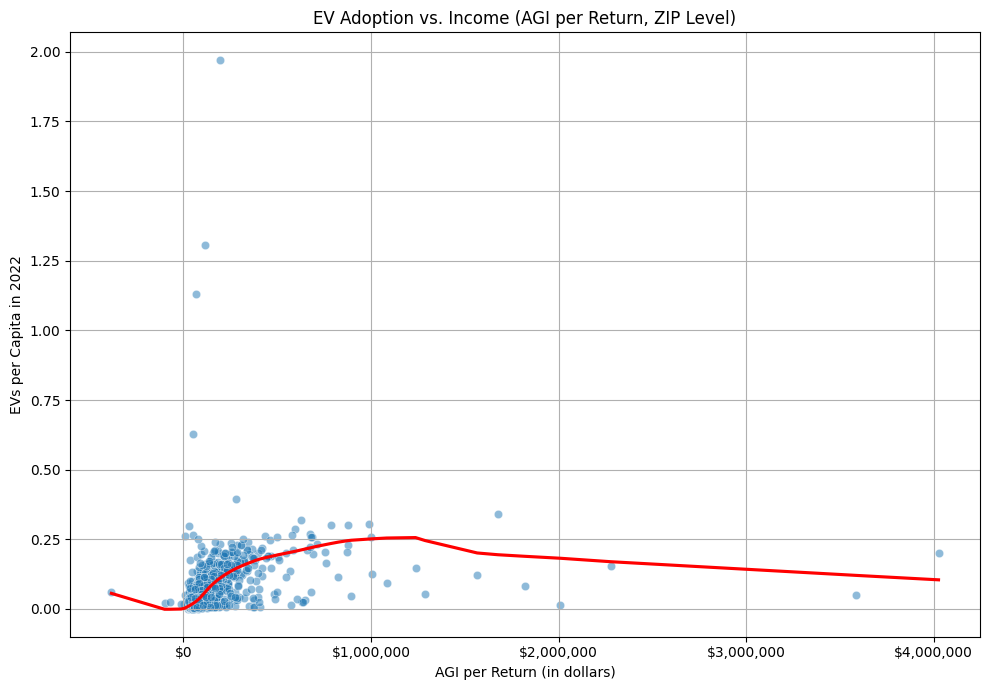

In [6]:
# Plot figure

import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaNs
plot_data = merged.dropna(subset=["AGI per Return", "EVs per Capita in 2022"])

import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=plot_data, x="AGI per Return", y="EVs per Capita in 2022", alpha=0.5)
sns.regplot(data=plot_data, x="AGI per Return", y="EVs per Capita in 2022", scatter=False, lowess=True, color="red")

plt.title("EV Adoption vs. Income (AGI per Return, ZIP Level)")
plt.xlabel("AGI per Return (in dollars)")
plt.ylabel("EVs per Capita in 2022")
plt.grid(True)

# Format x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${int(x):,}"))

plt.tight_layout()
plt.show()

In [9]:
# Interactive Version
import plotly.express as px

fig = px.scatter(
    plot_data,
    x="AGI per Return",
    y="EVs per Capita in 2022",
    hover_name="Zip Code",
    hover_data={"AGI per Return": True, "EVs per Capita in 2022": True},
    title="EV Adoption vs. Income (Hover to View ZIP Code)",
    labels={
        "AGI per Return": "AGI per Return",
        "EVs per Capita in 2022": "EVs per Capita"
    }
)

fig.update_traces(marker=dict(size=6, opacity=0.5))
fig.update_layout(
    height=600,
    width=800,
    xaxis_tickformat=",",  # Use commas for full thousands
    title="EV Adoption vs. Income (Hover to View ZIP Code)",
    xaxis_title="AGI per Return",
    yaxis_title="EVs per Capita"
)

fig.show()